In [ ]:
import pickle
import numpy as np

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Load all 5 training batches
data_list = []
labels_list = []

for i in range(1, 6):
    batch = unpickle(f"/content/data_batch_{i}")
    data_list.append(batch[b'data'])
    labels_list.extend(batch[b'labels'])

# Stack data vertically and convert labels to numpy array
data = np.vstack(data_list)  # shape: (50000, 3072)
labels = np.array(labels_list)  # shape: (50000,)


In [ ]:
data.shape

(50000, 3072)

In [ ]:
len(labels)

50000

In [ ]:
meta = unpickle("/content/batches.meta")
label_names = [label.decode('utf-8') for label in meta[b'label_names']]
print(label_names[0])

airplane


In [ ]:
for lable in label_names:
    print(lable)

airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck


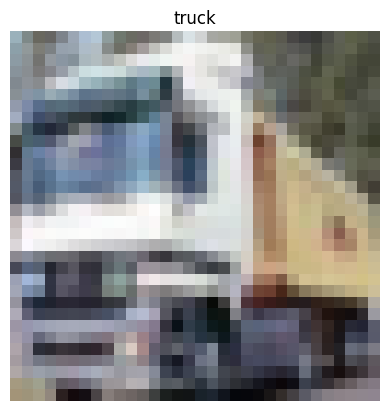

In [ ]:
import matplotlib.pyplot as plt

def convert_image(img_flat):
    # Reshape and transpose to get RGB image
    r = img_flat[0:1024].reshape(32, 32)
    g = img_flat[1024:2048].reshape(32, 32)
    b = img_flat[2048:].reshape(32, 32)
    return np.stack([r, g, b], axis=2)  # shape: (32, 32, 3)

# Display the first image
img = convert_image(data[1])
plt.imshow(img)
plt.title(label_names[labels[1]])
plt.axis('off')
plt.show()


In [ ]:
import pickle
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import timm
import torch.nn as nn
import torch.optim as optim
from PIL import Image

In [ ]:
class CIFAR10CustomDataset():
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_flat = self.data[idx]
        r = img_flat[0:1024].reshape(32, 32)
        g = img_flat[1024:2048].reshape(32, 32)
        b = img_flat[2048:].reshape(32, 32)
        img = np.stack([r, g, b], axis=2).astype(np.uint8)  # shape: (32, 32, 3)
        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        return img, self.labels[idx]

In [ ]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

In [ ]:
train_dataset = CIFAR10CustomDataset(data, labels, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, 10)  # CIFAR-10 has 10 classes
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-5)

epochs = 5  # You can increase this for better accuracy

In [ ]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    print(f"🔁 Starting epoch {epoch + 1}/{epochs}")

    for batch_idx, (images, targets) in enumerate(train_loader):
        try:
            images, targets = images.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if batch_idx % 50 == 0:
                print(f"Batch {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f}")
        except Exception as e:
            print(f"❌ Error in batch {batch_idx}: {e}")
            break  # or continue, depending on what you want

    avg_loss = running_loss / len(train_loader)
    print(f"✅ Epoch [{epoch + 1}/{epochs}] Avg Loss: {avg_loss:.4f}")


🔁 Starting epoch 1/5
Batch 0/782 | Loss: 2.6326
Batch 50/782 | Loss: 0.0402
Batch 100/782 | Loss: 0.1199
Batch 150/782 | Loss: 0.0687
Batch 200/782 | Loss: 0.1457
Batch 250/782 | Loss: 0.1472
Batch 300/782 | Loss: 0.1163
Batch 350/782 | Loss: 0.0700
Batch 400/782 | Loss: 0.0469
Batch 450/782 | Loss: 0.0175
Batch 500/782 | Loss: 0.0222
Batch 550/782 | Loss: 0.0272
Batch 600/782 | Loss: 0.1942
Batch 650/782 | Loss: 0.0674
Batch 700/782 | Loss: 0.0061
Batch 750/782 | Loss: 0.0948
✅ Epoch [1/5] Avg Loss: 0.1043
🔁 Starting epoch 2/5
Batch 0/782 | Loss: 0.0066
Batch 50/782 | Loss: 0.0055
Batch 100/782 | Loss: 0.0382
Batch 150/782 | Loss: 0.0083
Batch 200/782 | Loss: 0.0939
Batch 250/782 | Loss: 0.0921
Batch 300/782 | Loss: 0.0238
Batch 350/782 | Loss: 0.0130
Batch 400/782 | Loss: 0.0135
Batch 450/782 | Loss: 0.0478
Batch 500/782 | Loss: 0.0198
Batch 550/782 | Loss: 0.0390
Batch 600/782 | Loss: 0.0129
Batch 650/782 | Loss: 0.0062
Batch 700/782 | Loss: 0.1946
Batch 750/782 | Loss: 0.0039
✅ Epo

In [ ]:
torch.save(model.state_dict(), "vit_cifar10.pth")
print("Model saved as vit_cifar10.pth ✅")

In [ ]:
# ---------- Step 1: Load Test Batch ----------
test_batch = unpickle("/content/test_batch")
test_data = test_batch[b'data']
test_labels = np.array(test_batch[b'labels'])  # shape: (10000,)

# ---------- Step 2: Create Test Dataset ----------
class CIFAR10TestDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_flat = self.data[idx]
        r = img_flat[0:1024].reshape(32, 32)
        g = img_flat[1024:2048].reshape(32, 32)
        b = img_flat[2048:].reshape(32, 32)
        img = np.stack([r, g, b], axis=2).astype(np.uint8)
        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        return img, self.labels[idx]

test_dataset = CIFAR10TestDataset(test_data, test_labels, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

# ---------- Step 3: Load trained model if not already loaded ----------
model.load_state_dict(torch.load("/content/vit_cifar10.pth"))
model.eval()

# ---------- Step 4: Predict ----------
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total * 100
print(f"✅ Test Accuracy: {accuracy:.2f}%")


✅ Test Accuracy: 97.86%


✅ Predicted: automobile
🎯 Actual: automobile


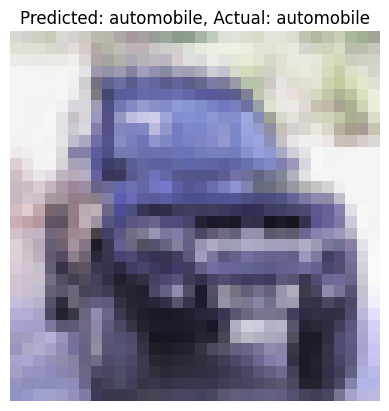

In [ ]:
idx = 9  # index of the image you want to test
test_img_flat = test_data[idx]

# Reconstruct RGB image
r = test_img_flat[0:1024].reshape(32, 32)
g = test_img_flat[1024:2048].reshape(32, 32)
b = test_img_flat[2048:].reshape(32, 32)
img_np = np.stack([r, g, b], axis=2).astype(np.uint8)
img_pil = Image.fromarray(img_np)

# Transform and predict
img_tensor = transform(img_pil).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(img_tensor)
    _, pred = torch.max(output, 1)

predicted_label = label_names[pred.item()]
true_label = label_names[test_labels[idx]]

print(f"✅ Predicted: {predicted_label}")
print(f"🎯 Actual: {true_label}")

# Show the image
import matplotlib.pyplot as plt
plt.imshow(img_np)
plt.title(f"Predicted: {predicted_label}, Actual: {true_label}")
plt.axis('off')
plt.show()


In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

def predict_image_from_path(image_path, model, transform, label_names, device):
    # Load and preprocess image
    img_pil = Image.open(image_path).convert('RGB')
    img_tensor = transform(img_pil).unsqueeze(0).to(device)

    # Run model prediction
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        _, pred = torch.max(output, 1)

    predicted_label = label_names[pred.item()]

    # Display result
    print(f"✅ Predicted Label: {predicted_label}")

    plt.imshow(img_pil)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

    return predicted_label


✅ Predicted Label: airplane


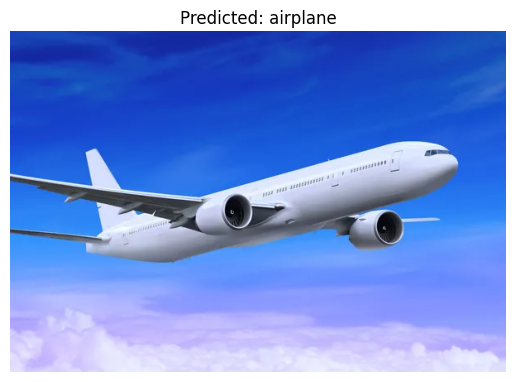

'airplane'

In [ ]:
image_path = "/content/depositphotos_4755326-stock-photo-white-passenger-plane-landing-away.jpg"  # <-- change this to your image file path
predict_image_from_path(image_path, model, transform, label_names, device)


In [ ]:
"widgets": {
  "application/vnd.jupyter.widget-state+json": {
    "version_major": 2,
    "version_minor": 0,
    "state": {}
  }
}
